In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torch.nn.functional as F
import torch.nn.init as init
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import random
from os.path import dirname, join as pjoin
import copy
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('visualization.ipynb'), '../')))
from utils.networks import *
from utils.trainer import *
from utils.formulations import *

datafolderpath = '../experiment/input_data'
saveresultfolderpath = '../experiment/experimental_result'
figurefolderpath = './saved_figures/'

alldgpresult_filename = {dgp: [f"{method}_tradeoff_dgp{dgp}_done.pkl" for method in ['sumk', 'qd', 'cwcquan', 'cwcshri', 'cwcli']] +
         [f"{perf_method}_performance_dgp{dgp}_done.pkl" for perf_method in ['qr', 'qrf', 'mve', 'dic', 'mcdropout', 'deepensemble']]
    for dgp in ['gaussian', 'sin', 'multivariate']}

alldgp_filename = {dgp: f"dgp_{dgp}_100trials.pkl" for dgp in ['gaussian', 'polynomial', 'sin', 'multivariate']}

def report_savefig(plotname, resultfolderpath = './', formattype = 'pdf', pad_margin = 0.01):
    fig.savefig(resultfolderpath + plotname + f'.{formattype}',format=formattype, 
                bbox_inches='tight',pad_inches=pad_margin,transparent=True)

# Import result

In [2]:
# The choice of dgpresult_key are 'gaussian', 'polynomial', 'sin', 'multivariate'
dgpresult_key = 'gaussian' 
dataname = 'Sum of Gaussian function'

# dgpresult_key = 'sin' 
# dataname = 'Sinusoid function'

# dgpresult_key = 'multivariate' 
# dataname = 'Multivariate function'

allresult_filename = alldgpresult_filename[dgpresult_key]
data_filename = alldgp_filename[dgpresult_key]

index_path = next((i for i, s in enumerate(allresult_filename) if 'sumk' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_sumk = pickle.load(pickle_file)
print(result_sumk.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'qd' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qd = pickle.load(pickle_file)
print(result_qd.keys()) 

index_path = next((i for i, s in enumerate(allresult_filename) if 'cwcquan' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_cwcquan = pickle.load(pickle_file)
print(result_cwcquan.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'cwcshri' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_cwcshri = pickle.load(pickle_file)
print(result_cwcshri.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'cwcli' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_cwcli = pickle.load(pickle_file)
print(result_cwcli.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'dic_' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_dic = pickle.load(pickle_file)
print(result_dic.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'qr_' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qr = pickle.load(pickle_file)
print(result_qr.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'qrf_' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qrf = pickle.load(pickle_file)
print(result_qrf.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'mve' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_mve = pickle.load(pickle_file)
print(result_mve.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'mcdropout' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_mcdropout = pickle.load(pickle_file)
print(result_mcdropout.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'deepensemble' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_deepensemble = pickle.load(pickle_file)
print(result_deepensemble.keys())


## Load
dict_path = os.path.join(datafolderpath, data_filename)
with open(dict_path, 'rb') as pickle_file:
    data = pickle.load(pickle_file)
x = data['x']
y_all_trials = data['y_all_trials']
y_true = data['y_true']
N_trials = y_all_trials.shape[1]

X_input = torch.tensor(x, dtype = torch.float)

##### Select what to plot
color_list = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple']
formname = ['Sumk', 'QD', 'CWCquan', 'CWCshri', 'CWCli', 'MCdropout', 'DeepEnsemble']
method_list =  [result_sumk, result_qd, result_cwcquan, result_cwcshri, result_cwcli
                , result_mcdropout, result_deepensemble]

dict_keys(['outputs_train', 'outputs_val', 'PICP_val', 'PINAW', 'PINALW', 'PIwidth', 'allytrain', 'allxtrain', 'allyval', 'allxval', 'gamma', 'lambda', 'klargest', 'Winkler'])
dict_keys(['outputs_train', 'outputs_val', 'PICP_val', 'PINAW', 'PINALW', 'PIwidth', 'allytrain', 'allxtrain', 'allyval', 'allxval', 'gamma', 'Winkler'])
dict_keys(['outputs_train', 'outputs_val', 'PICP_val', 'PINAW', 'PINALW', 'PIwidth', 'allytrain', 'allxtrain', 'allyval', 'allxval', 'gamma', 'Winkler'])
dict_keys(['outputs_train', 'outputs_val', 'PICP_val', 'PINAW', 'PINALW', 'PIwidth', 'allytrain', 'allxtrain', 'allyval', 'allxval', 'gamma', 'Winkler'])
dict_keys(['outputs_train', 'outputs_val', 'PICP_val', 'PINAW', 'PINALW', 'Winkler', 'PIwidth', 'allytrain', 'allxtrain', 'allyval', 'allxval', 'gamma', 'alpha', 'beta'])
dict_keys(['outputs_train', 'outputs_val', 'PICP_val', 'PINAW', 'PINALW', 'Winkler', 'PIwidth', 'allytrain', 'allxtrain', 'allyval', 'allxval'])
dict_keys(['outputs_train', 'outputs_val', 'PI

# Trade-off curve result

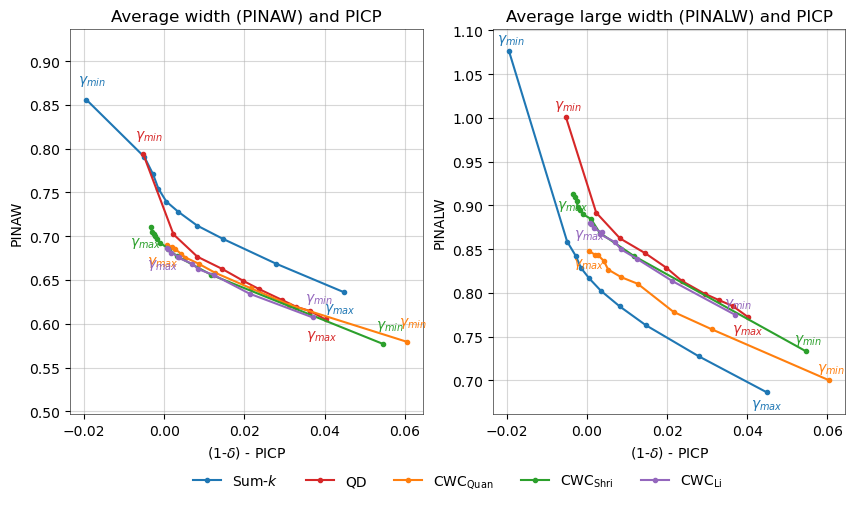

In [3]:
color_list = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green', 'tab:purple']
formname = ['Sum-$k$', 'QD', r'$\text{CWC}_{\text{Quan}}$', r'$\text{CWC}_{\text{Shri}}$', r'$\text{CWC}_{\text{Li}}$']
method_list =  [result_sumk, result_qd, result_cwcquan, result_cwcshri, result_cwcli]

delta = 0.1
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))
min_max_array = np.zeros((len(method_list), 3, 2))

for i, method in enumerate(method_list):
    PICP_plot = np.mean(method['PICP_val'], axis = -1)
    PINAW_plot = np.mean(method['PINAW'], axis = -1)
    PINALW_plot = np.mean(method['PINALW'], axis = -1)
    quantile = 0.5
    PINMW_plot = np.mean(np.quantile(method['PIwidth'], q = quantile, axis = 0), axis = -1)
    
    ax[0].plot((1-delta) - PICP_plot, PINAW_plot, marker = '.', label = formname[i], color = color_list[i])
    ax[0].set_title('Average width (PINAW) and PICP')
    ax[0].set_ylabel('PINAW')
    min_max_array[i, 0, 0] = np.min(PINAW_plot)
    min_max_array[i, 0, 1] = np.max(PINAW_plot)

    ax[1].plot((1-delta) - PICP_plot, PINALW_plot, marker = '.', label = formname[i], color = color_list[i])
    ax[1].set_title('Average large width (PINALW) and PICP')
    ax[1].set_ylabel('PINALW')
    min_max_array[i, 1, 0] = np.min(PINALW_plot)
    min_max_array[i, 1, 1] = np.max(PINALW_plot)
    gamma_values = method['gamma']
    
    ax[0].text((1 - delta) - PICP_plot[0] + 0.005, PINAW_plot[0] + 0.03, f'$\gamma_{{min}}$',
               color=color_list[i], fontsize=10, ha='right', va='top')
    ax[0].text((1 - delta) - PICP_plot[-1] - 0.005, PINAW_plot[-1] - 0.01, f'$\gamma_{{max}}$',
               color=color_list[i], fontsize=10, ha='left', va='top')

    ax[1].text((1 - delta) - PICP_plot[0] + 0.004, PINALW_plot[0] + 0.005, f'$\gamma_{{min}}$',
               color=color_list[i], fontsize=10, ha='right', va='bottom')
    ax[1].text((1 - delta) - PICP_plot[-1] - 0.004, PINALW_plot[-1] - 0.005, f'$\gamma_{{max}}$',
               color=color_list[i], fontsize=10, ha='left', va='top')
    
# range_array = min_max_array[:,:,1] - min_max_array[:,:,0]
min_element = np.min(min_max_array[:, :, 0], axis = 0)
max_element = np.max(min_max_array[:, :, 1], axis = 0)
range_array = max_element - min_element

# # Set same limits and ticks for all axes
maxrange_all = np.max(range_array) 
add_range = (maxrange_all - range_array)/2 + 0.025

for i in range(2):
#     ax[i].set_xlim(xlim)
    ax[i].set_ylim((min_element[i] - add_range[i], max_element[i] + add_range[i]))
    ax[i].grid(True, which = 'both', alpha = 0.5)
    ax[i].set_xlabel(r'(1-$\delta$) - PICP')
#     ax[i].legend(loc = 'upper right')
ax[1].legend(loc='upper center', fontsize=10, ncol=5, bbox_to_anchor=(-0.1, -0.12), frameon = False)
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)
plt.show()

# report_savefig(f'tradeoffcurve_dgpnewlast{dgpresult_key}', resultfolderpath = figurefolderpath, pad_margin = 0.01)

# PI characteristics

For Sum-$k$: gamma = 0.0889
For QD: gamma = 0.0056
For $\text{CWC}_{\text{Quan}}$: gamma = 7.2222
For $\text{CWC}_{\text{Shri}}$: gamma = 2.2222
For $\text{CWC}_{\text{Li}}$: gamma = 8.3333


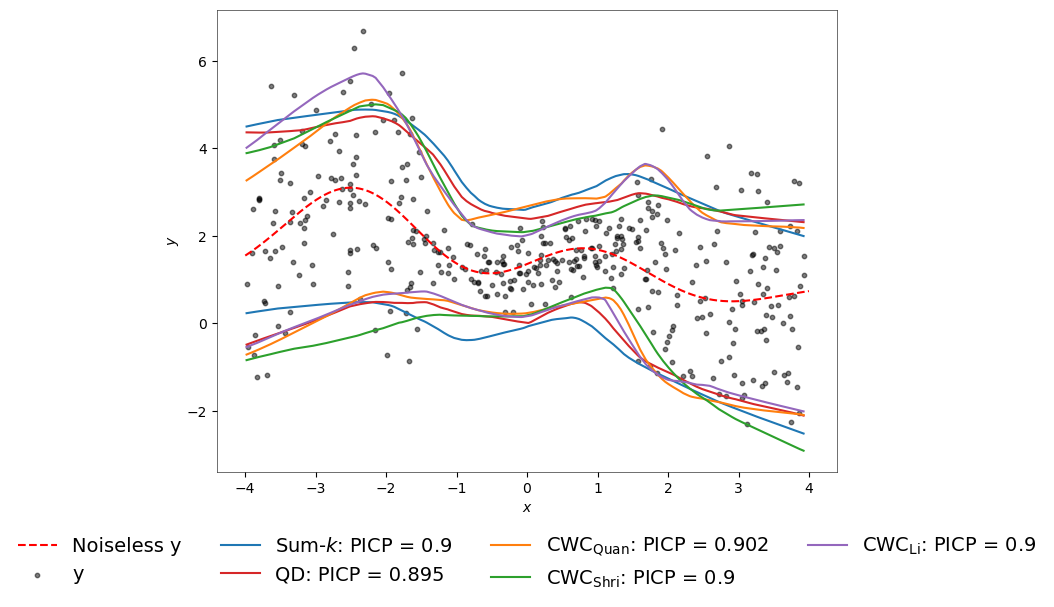

In [4]:
color_list = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green', 'tab:purple']
formname = ['Sum-$k$', 'QD', r'$\text{CWC}_{\text{Quan}}$', r'$\text{CWC}_{\text{Shri}}$', r'$\text{CWC}_{\text{Li}}$']
method_list =  [result_sumk, result_qd, result_cwcquan, result_cwcshri, result_cwcli]

dataindex = 95
picp_target = 0.9
train = trainer(num_epochs = 2000, batch_size = 2000, patience = 200) #Set the trainer

fig, ax = plt.subplots(figsize=(8, 6))
for i, method in enumerate(method_list):
    xplot, yplot = train.sort_x_toplot(method['allxval'][:, :, dataindex], method['allyval'][:, dataindex])
    if x.shape[1] > 1:
        sampleplot = 20  # For a multivariate function only
        xindex_plot = np.arange(x[:sampleplot].shape[0], dtype=int)
        xplot = xindex_plot
        ax.set_xlabel(r'Sample index')
        x_all = xindex_plot
    else:
        sampleplot = None
        ax.set_xlabel(r'$x$')
        x_all = x
    if i == 0:
        ax.plot(x_all, y_true[:sampleplot], color='red', linestyle='dashed', label='Noiseless y')
        ax.scatter(xplot, yplot[:sampleplot], s=10, alpha=0.5, color='black', label='y')
        
    index_gamma = np.argmin(np.abs(method['PICP_val'][:, dataindex] - picp_target))
    if index_gamma == 0 and method['gamma'][index_gamma] < 1e-4:
        index_gamma += 1
    gamma_plot = method['gamma'][index_gamma]
    print(f'For {formname[i]}: gamma = {round(gamma_plot, 4)}')
    picp_gamma = round(method['PICP_val'][index_gamma, dataindex], 3)
    upper = method['outputs_val'][:sampleplot, 1, index_gamma, dataindex]
    lower = method['outputs_val'][:sampleplot, 0, index_gamma, dataindex]
    ax.plot(xplot, upper, color=color_list[i], label=f'{formname[i]}: PICP = {picp_gamma}')
    ax.plot(xplot, lower, color=color_list[i])

ax.set_ylabel(r'$y$')

# Move the legend below the plot with two columns
ax.legend(loc='upper center', fontsize=14, ncol=4, bbox_to_anchor=(0.5, -0.1), frameon = False)

for spine in ax.spines.values():
    spine.set_linewidth(0.4)
plt.show()

# report_savefig(f'piresult_dgp{dgpresult_key}', resultfolderpath = figurefolderpath, formattype = 'pdf', pad_margin = 0.01)

# PI width Histogram

In [ ]:
def PIhistogramplot(method_list, formname, color_list, picp_target=0.9, graphborderwidth=1):
    nrows = 3
    total_methods = len(method_list) - 1  # exclude reference method
    ncols = (total_methods + nrows - 1) // nrows

    fig = plt.figure(figsize=(nrows * 5, ncols * 3))
    gs = GridSpec(nrows, ncols, figure=fig)
    axes = []

    # Determine total number of plots and how many are in the last row
    plots_per_row = ncols
    total_plots = total_methods
    full_rows = total_plots // plots_per_row
    plots_in_last_row = total_plots % plots_per_row

    # Compute global bin range
    global_min = np.inf
    global_max = -np.inf

    for method in method_list:
        if 'gamma' in method:
            index_gamma = np.argmin(np.abs(np.mean(method['PICP_val'], axis=-1) - picp_target))
            if abs(method['gamma'][index_gamma]) < 1e-7:
                index_gamma += 1
            width_plot = method['PIwidth'][:, index_gamma, :].reshape(-1)
        else:
            width_plot = method['PIwidth'].reshape(-1)
        global_min = min(global_min, np.min(width_plot))
        global_max = max(global_max, np.max(width_plot))

    binwidth = 0.02
    bins = np.arange(global_min, global_max + binwidth, binwidth)

    # Reference method
    our_method = method_list[0]
    index_gamma_our = np.argmin(np.abs(np.mean(our_method['PICP_val'], axis=-1) - picp_target))
    our_picp_gamma = round(np.mean(our_method['PICP_val'], axis=-1)[index_gamma_our], 3)
    if index_gamma_our == 0:
        index_gamma_our += 1
    width_plot_our = our_method['PIwidth'][:, index_gamma_our, :].reshape(-1)
    hist_our, _ = np.histogram(width_plot_our, bins=bins, density=False)
    hist_our = hist_our / np.sum(hist_our)

    # Loop through comparison methods
    for idx, method in enumerate(method_list[1:], start=1):
        row = (idx - 1) // ncols
        col = (idx - 1) % ncols

        # Adjust column index for centered last row
        if row == nrows - 1 and plots_in_last_row != 0:
            offset = (ncols - plots_in_last_row) // 2
            col += offset

        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)

        if 'gamma' in method:
            index_gamma = np.argmin(np.abs(np.mean(method['PICP_val'], axis=-1) - picp_target))
            if abs(method['gamma'][index_gamma]) < 1e-7:
                index_gamma += 1
            gamma_plot = method['gamma'][index_gamma]
            picp_gamma = round(np.mean(method['PICP_val'], axis=-1)[index_gamma], 3)
            width_plot = method['PIwidth'][:, index_gamma, :].reshape(-1)
        else:
            picp_gamma = round(np.mean(method['PICP_val'], axis=0), 3)
            width_plot = method['PIwidth'].reshape(-1)

        hist_data, bin_edges = np.histogram(width_plot, bins=bins, density=False)
        hist_data = hist_data / np.sum(hist_data)

        ax.bar(bin_edges[:-1], hist_our, width=binwidth, alpha=0.6,
               label=f'{formname[0]}: PICP = {our_picp_gamma}', color=color_list[0], edgecolor='black', linewidth=0.5)
        ax.axvline(np.mean(width_plot_our), color=color_list[0], linestyle='dashed', linewidth=2,
                   label=f'{formname[0]}: Avg. width = {round(np.mean(width_plot_our), 3)}')

        ax.bar(bin_edges[:-1], hist_data, width=binwidth, alpha=0.6,
               label=f'{formname[idx]}: PICP = {picp_gamma}', color=color_list[idx], edgecolor='black', linewidth=0.5)
        ax.axvline(np.mean(width_plot), color=color_list[idx], linestyle='dashed', linewidth=2,
                   label=f'{formname[idx]}: Avg. width = {round(np.mean(width_plot), 3)}')

        ax.set_title(f'{formname[0]} vs {formname[idx]}', fontsize=14)
        ax.set_xlabel('Normalized PI width')
        ax.set_ylabel('Normalized frequency')
        global_max = global_max*(global_max < 2.5) + 2.5*(global_max >= 2.5)
        ax.set_xlim(global_min - 0.05, global_max + 0.05)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    # Hide all unused GridSpec positions
    for row in range(nrows):
        for col in range(ncols):
            plot_idx = row * ncols + col
            if plot_idx >= total_plots:
                if plots_in_last_row != 0 and row == nrows - 1:
                    offset = (ncols - plots_in_last_row) // 2
                    if col < offset or col >= offset + plots_in_last_row:
                        ax = fig.add_subplot(gs[row, col])
                        ax.axis('off')
                else:
                    ax = fig.add_subplot(gs[row, col])
                    ax.axis('off')

    for ax in axes:
        for spine in ax.spines.values():
            spine.set_linewidth(graphborderwidth)

    plt.tight_layout()
    return fig

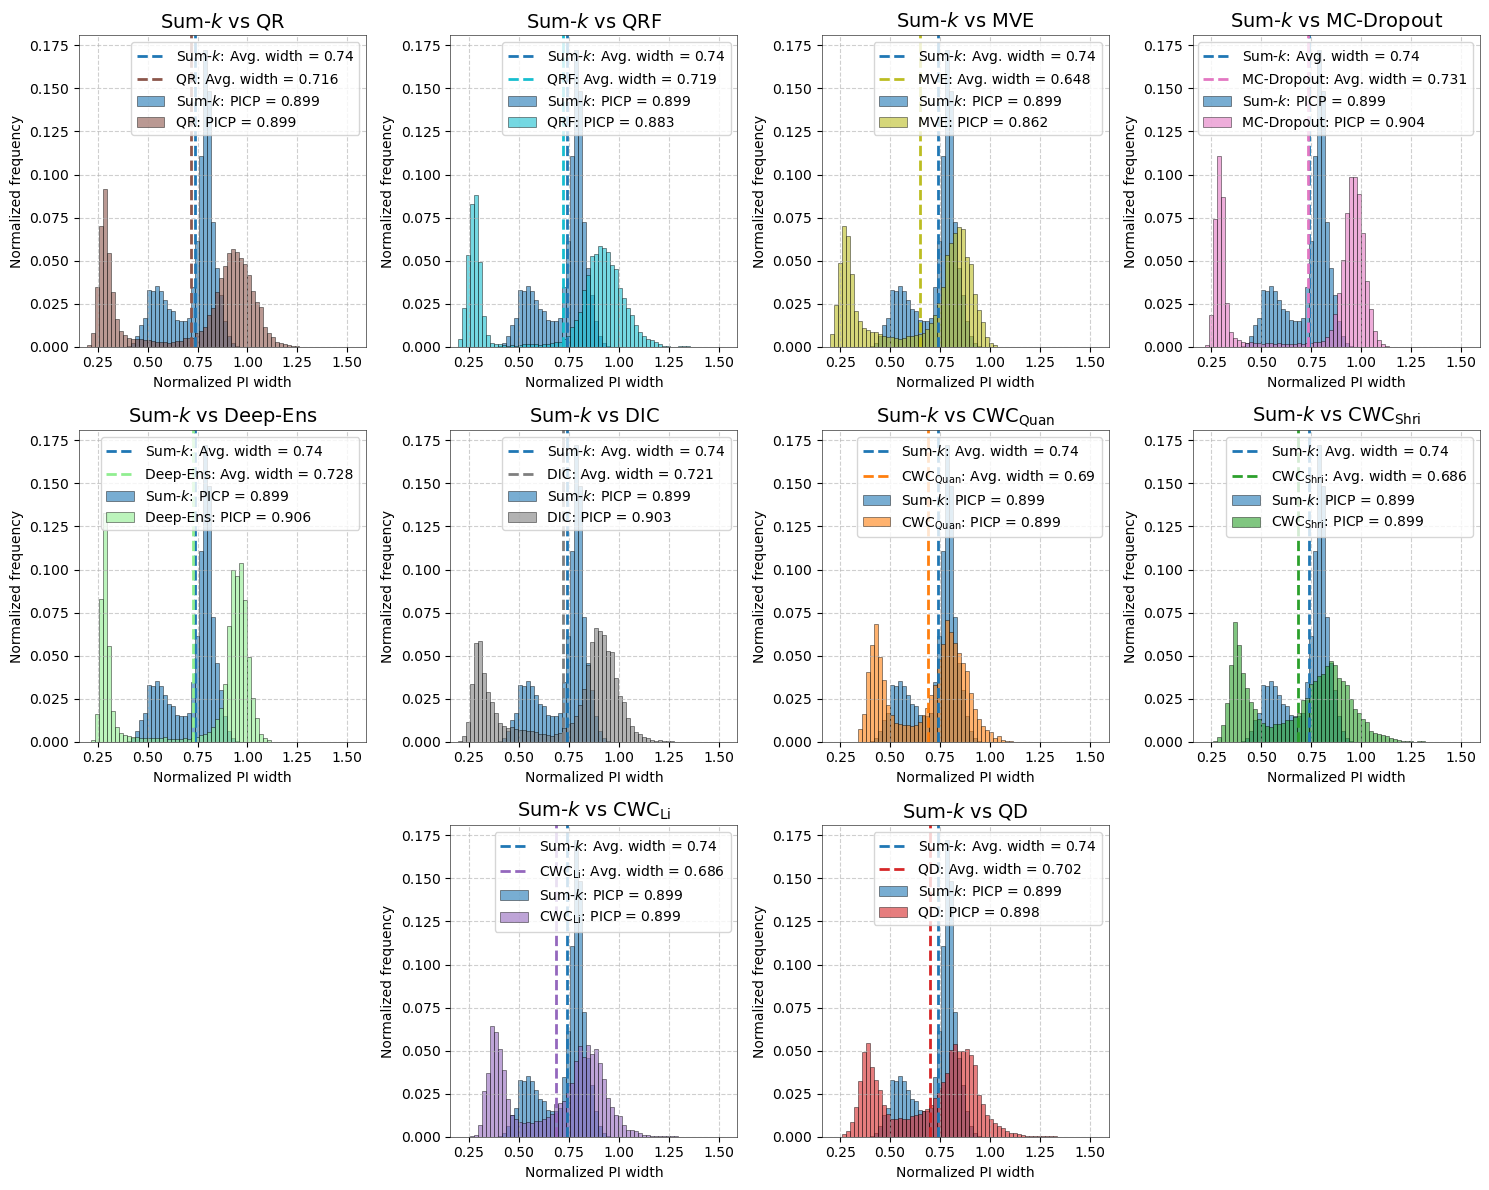

In [5]:
color_list = ['tab:blue', 'tab:brown', 'tab:cyan', 'tab:olive', 'tab:pink', 'lightgreen', 'tab:gray', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']
formname = ['Sum-$k$', 'QR', 'QRF', 'MVE', 'MC-Dropout', 'Deep-Ens', 'DIC', r'$\text{CWC}_{\text{Quan}}$'
            , r'$\text{CWC}_{\text{Shri}}$', r'$\text{CWC}_{\text{Li}}$', 'QD']
method_list = [result_sumk, result_qr, result_qrf, result_mve, result_mcdropout, result_deepensemble
               , result_dic, result_cwcquan, result_cwcshri, result_cwcli
               , result_qd]
fig = PIhistogramplot(method_list, formname, color_list, picp_target = 0.9, graphborderwidth = 0.4)
plt.show()

# report_savefig(f'hist_piwidth_horizontal_dgp{dgpresult_key}_mod', resultfolderpath = figurefolderpath, pad_margin = 0.01)